In [1]:
!pip install stumpy --user

In [2]:
import pandas as pd
import numpy as np
from tensorflow.python.ops import nn_ops, gen_nn_ops
import tensorflow as tf

In [0]:
class CNN_MC_dropout:
    def __init__(self, std=0.01, batch_size=64,width=500, height =1, input_channel=3, nb_classes=2, l_rate =1e-6,reuse = False):
        self.std=std
        self.batch_size=batch_size
        self.height = height
        self.width = width
        self.input_channel = input_channel
        self.l_rate = l_rate
        
        self.nb_classes = nb_classes

        with tf.name_scope('Classifier'):
            self.y = tf.placeholder(tf.float32, [None, self.nb_classes], name='y')
            self.x = tf.placeholder(tf.float32, [None, self.height,self.width,self.input_channel], name='x')
            self.keep_prob = tf.placeholder(tf.float32)
            self.is_dropout = tf.placeholder(tf.bool)
        
        # keep prob가 1보다 작으면, 드랍아웃을 한다는 의미
        #self.dropout_bool = True#tf.cond(self.keep_prob < 1.0, lambda: tf.constant(True), lambda: tf.constant(False))
        
        self.logits = self.build_model()

        # Define loss and optimizer, minimize the squared error
        self.cross_entropy =  tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.logits)
        self.cost =tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(self.l_rate).minimize(self.cost)

        self.correct_pred = tf.equal(tf.round(self.prediction),self.y)
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

        init = tf.global_variables_initializer()

        # Launch the session
        self.session_conf = tf.ConfigProto()
        self.session_conf.gpu_options.allow_growth = True
        self.sess = tf.InteractiveSession(config=self.session_conf)
        self.sess.run(init)

        self.saver = tf.train.Saver(max_to_keep=None)

    def build_model(self):
        with tf.variable_scope('layer0'):
            #b, h, w, c
            self.input = self.x
        # Convolutional Layer #1 and Pooling Layer #1
        with tf.variable_scope('layer1'):
            self.conv1 = tf.layers.conv2d(self.input, 128, [8,1], padding='SAME')
            self.batch1 = tf.layers.batch_normalization(self.conv1)
            self.relu1 = tf.nn.relu(self.batch1)
            self.dropout1 = tf.nn.dropout(self.relu1, self.keep_prob)

        # Convolutional Layer #1 and Pooling Layer #2
        with tf.variable_scope('layer2'):
            self.conv2 = tf.layers.conv2d(self.dropout1, 256, [5,1], padding='SAME')
            self.batch2 = tf.layers.batch_normalization(self.conv2)
            self.relu2 = tf.nn.relu(self.batch2)
            self.dropout2 = tf.nn.dropout(self.relu2, self.keep_prob)

        # Convolutional Layer #1 and Pooling Layer #3
        with tf.variable_scope('layer3'):
            self.conv3 = tf.layers.conv2d(self.dropout2, 128, [3,1], padding='SAME')
            self.batch3 = tf.layers.batch_normalization(self.conv3)
            self.relu3 = tf.nn.relu(self.batch3)

        # Dense Layer with Relu
        with tf.variable_scope('layer4'):
            #Global Average Pooling
            self.GAP = tf.reduce_mean(self.relu3, axis=[1,2])# b,h,w,c
            self.logits = tf.layers.dense(self.GAP,self.nb_classes)
            self.prediction = tf.nn.softmax(self.logits)
            
        return self.logits


    def train(self, data, target, keep_prob,is_dropout):
        opt, cost ,acc = self.sess.run((self.optimizer, self.cost, self.accuracy ), 
                             feed_dict={self.y: target,
                                        self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return cost,acc

    def test(self, data, target, keep_prob,is_dropout):
        cost,acc = self.sess.run((self.cost,self.accuracy),
                             feed_dict={self.y: target,
                                        self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return cost,acc

    def get_last_conv_output(self, data, keep_prob,is_dropout):
        relu3 =  self.sess.run((self.relu3), 
                             feed_dict={self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return relu3
    
    def predict(self, data, keep_prob,is_dropout):

        prediction =  self.sess.run((self.prediction), 
                             feed_dict={self.x: data,
                                       self.keep_prob: keep_prob,
                                       self.is_dropout : is_dropout})
        return prediction

    def save(self, save_path='./model.ckpt'):
        saved_path = self.saver.save(self.sess, save_path)
        print("Model saved in file: %s"%saved_path)

    def load(self, load_path = './model.ckpt'):
        self.saver.restore(self.sess, load_path)
        print("Model restored")

    def terminate(self):
        self.sess.close()
        tf.reset_default_graph() 

# 1. Data Load
### 전처리 width, height, input_channel 정의

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
labels = {1:'WALKING', 2:'WALKING UPSTAIRS', 3:'WALKING DOWNSTAIRS',
          4:'SITTING', 5:'STANDING', 6:'LAYING'}

In [6]:
cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
(347, 128, 9) (347, 1)


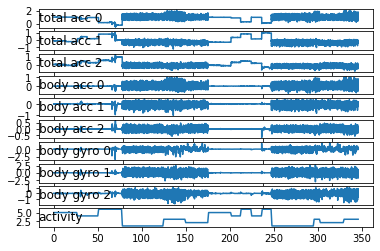

In [7]:
# plot all vars for one subject
from numpy import array
from numpy import dstack
from numpy import unique
from pandas import read_csv
from matplotlib import pyplot
 
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values
 
# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y
 
# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
	# get row indexes for the subject id
	ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
	# return the selected samples
	return X[ix, :, :], y[ix]
 
# convert a series of windows to a 1D list
def to_series(windows):
	series = list()
	for window in windows:
		# remove the overlap from the window
		half = int(len(window) / 2) - 1
		for value in window[-half:]:
			series.append(value)
	return series
 
# plot the data for one subject
def plot_subject(X, y):
	pyplot.figure()
	# determine the total number of plots
	n, off = X.shape[2] + 1, 0
	# plot total acc
	for i in range(3):
		pyplot.subplot(n, 1, off+1)
		pyplot.plot(to_series(X[:, :, off]))
		pyplot.title('total acc '+str(i), y=0, loc='left')
		off += 1
	# plot body acc
	for i in range(3):
		pyplot.subplot(n, 1, off+1)
		pyplot.plot(to_series(X[:, :, off]))
		pyplot.title('body acc '+str(i), y=0, loc='left')
		off += 1
	# plot body gyro
	for i in range(3):
		pyplot.subplot(n, 1, off+1)
		pyplot.plot(to_series(X[:, :, off]))
		pyplot.title('body gyro '+str(i), y=0, loc='left')
		off += 1
	# plot activities
	pyplot.subplot(n, 1, n)
	pyplot.plot(y)
	pyplot.title('activity', y=0, loc='left')
	pyplot.show()
 
# load data
x_train, y_train = load_dataset('train', 'HARDataset/')
# load mapping of rows to subjects
train_sub_map = load_file('HARDataset/train/subject_train.txt')
train_subjects = unique(train_sub_map)
print(train_subjects)
# get the data for one subject
train_sub_id = train_subjects[0]
train_subX, train_suby = data_for_subject(x_train, y_train, train_sub_map, train_sub_id)
print(train_subX.shape, train_suby.shape)
# plot data for subject
plot_subject(train_subX, train_suby)

[ 2  4  9 10 12 13 18 20 24]
(302, 128, 9) (302, 1)


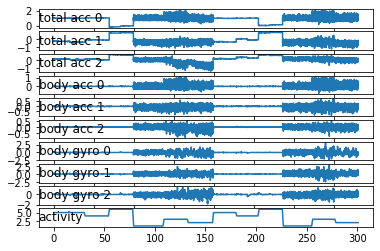

In [8]:
# load data
x_test, y_test = load_dataset('test', 'HARDataset/')
# load mapping of rows to subjects
test_sub_map = load_file('HARDataset/test/subject_test.txt')
test_subjects = unique(test_sub_map)
print(test_subjects)
# get the data for one subject
test_sub_id = test_subjects[0]
test_subX, test_suby = data_for_subject(x_test, y_test, test_sub_map, test_sub_id)
print(test_subX.shape, test_suby.shape)
# plot data for subject
plot_subject(test_subX, test_suby)

In [0]:
hot_encoded_y_train = np.asarray(pd.get_dummies(np.asarray(train_suby.squeeze())))
hot_encoded_y_test = np.asarray(pd.get_dummies(np.asarray(test_suby.squeeze())))

In [0]:
trainX = train_subX[:, np.newaxis, :, :]
trainY = hot_encoded_y_train

validX =test_subX[:len(test_subX)//2, np.newaxis, :,:]
validY= hot_encoded_y_test[:len(test_suby)//2]

testX = test_subX[len(test_subX)//2:, np.newaxis, :,:]
testY = hot_encoded_y_test[len(test_suby)//2:]

height = trainX.shape[1]
width = trainX.shape[2]
input_channel = trainX.shape[3]

# 2. Training condition 정의

In [0]:
t_loss=[]
t_acc=[]

v_loss=[]
v_acc=[]

val_freq = 1
save_freq = 1
num_epochs= 100

std= 0.01
batch_size = len(trainX)//10
l_rate = 1e-3

In [0]:
train_history = pd.DataFrame(index=np.arange(0, num_epochs), columns=['epoch', 'loss', 'acc','timestamp'])
valid_history = pd.DataFrame(index=np.arange(0, num_epochs/val_freq),columns=['epoch', 'loss', 'acc','timestamp'])

# 3. model structure 정의

In [0]:
nb_classes = 6

In [14]:
if 'MC_dropout_model' in globals():
    MC_dropout_model.terminate()
    
MC_dropout_model =CNN_MC_dropout(height=height,width= width, input_channel=input_channel ,nb_classes=nb_classes,
                                 std=std,batch_size=batch_size,l_rate=l_rate)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.Dense instead.


In [15]:
print (MC_dropout_model.input)
print ('[layer1] - MC dropout')
print (MC_dropout_model.conv1)
print (MC_dropout_model.batch1)
print (MC_dropout_model.relu1)
print (MC_dropout_model.dropout1)
print ('[layer2] - MC dropout')
print (MC_dropout_model.conv2)
print (MC_dropout_model.batch2)
print (MC_dropout_model.relu2)
print (MC_dropout_model.dropout2)
print ('[layer3]')
print (MC_dropout_model.conv3)
print (MC_dropout_model.batch3)
print (MC_dropout_model.relu3)

print ('[layer4]')
print (MC_dropout_model.GAP)
print (MC_dropout_model.logits)

Tensor("Classifier/x:0", shape=(?, 1, 128, 9), dtype=float32)
[layer1] - MC dropout
Tensor("layer1/conv2d/BiasAdd:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer1/batch_normalization/FusedBatchNormV3:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer1/Relu:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer1/dropout/mul_1:0", shape=(?, 1, 128, 128), dtype=float32)
[layer2] - MC dropout
Tensor("layer2/conv2d/BiasAdd:0", shape=(?, 1, 128, 256), dtype=float32)
Tensor("layer2/batch_normalization/FusedBatchNormV3:0", shape=(?, 1, 128, 256), dtype=float32)
Tensor("layer2/Relu:0", shape=(?, 1, 128, 256), dtype=float32)
Tensor("layer2/dropout/mul_1:0", shape=(?, 1, 128, 256), dtype=float32)
[layer3]
Tensor("layer3/conv2d/BiasAdd:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer3/batch_normalization/FusedBatchNormV3:0", shape=(?, 1, 128, 128), dtype=float32)
Tensor("layer3/Relu:0", shape=(?, 1, 128, 128), dtype=float32)
[layer4]
Tensor("layer4/Mean:0", shape=(?, 128),

# 4. Training

In [0]:
import time
import os

In [0]:
keep_prob =1.0

In [18]:
save_path = '/content/drive/My Drive/Colab Notebooks/Explaining_Decision_of_Time_Series_Data/savedmodel'
model_name = 'ICML(har)_CNN_MCdropout'+str(keep_prob)+'_'+str(l_rate)+'_'+str(batch_size)
print (model_name)

ICML(har)_CNN_MCdropout1.0_0.001_34


In [0]:
def get_batch(X, Y,  batch_size=batch_size, shuffle=False):
    """
    dataset: numpy ndarray. dim=2
    
    dataset_input = normalized_data[:, input_idx]
    dataset_target = normalized_data[:, target_idx]
    interested_indices = train_indices
    """    
    assert np.isnan(X).any()==False
    assert np.isnan(Y).any()==False
    
    interested_indices = range(0,len(X))

    if shuffle:
        np.random.shuffle(interested_indices)
        
    for i in range(0, len(X)-batch_size, batch_size):
        batch_Xlist = []
        batch_Ylist = [] 
        
        batch_indices = interested_indices[i:i+batch_size]

        batch_Xlist.append(X[batch_indices])
        batch_Ylist.append(Y[batch_indices])

            
        batch_Xlist = np.asarray(batch_Xlist)
        batch_Xlist = batch_Xlist.reshape(-1,X.shape[1],X.shape[2],X.shape[3])
        
        batch_Ylist = np.asarray(batch_Ylist)
        batch_Ylist = batch_Ylist.reshape(-1,nb_classes)

        yield batch_Xlist, batch_Ylist

In [20]:
for epoch in range(num_epochs):#range(num_epochs):##
    
    loss = 0
    acc=0
    train_batches = 0
    start_time = time.time()   
    
    for batch in get_batch(X=trainX, Y=trainY, batch_size=batch_size):
        train_in, train_target = batch
        train_batches += 1.0 
        loss1 ,acc1 = MC_dropout_model.train(data=train_in,target= train_target,keep_prob=keep_prob,is_dropout=False)
        loss = loss1+loss
        acc = acc1+acc
        if np.isnan(loss):
            print ('error')
            break
    t_loss.append(loss/train_batches)
    t_acc.append(acc/train_batches)
    
    train_history.loc[epoch] = [epoch+1, t_loss[epoch], t_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]
    if not os.path.exists(os.path.join(save_path, model_name)):
        os.mkdir( os.path.join(save_path, model_name))
    MC_dropout_model.save(os.path.join(save_path, model_name,str(epoch+1)+'.ckpt'))

    
    if(epoch+1)%val_freq ==0:
        acc=0
        loss = 0
        val_batches=0
        for batch in get_batch(X=validX, Y=validY, batch_size=batch_size):
            val_in, val_target = batch
            val_batches += 1.0 
            loss1 ,acc1 = MC_dropout_model.test(data=val_in,target= val_target,keep_prob=keep_prob,is_dropout=False)
            loss = loss1+loss
            acc = acc1+acc
        
        v_acc.append(acc/val_batches)
        v_loss.append(loss/val_batches)
        valid_history.loc[epoch] = [epoch+1, v_loss[epoch], v_acc[epoch] ,time.strftime("%Y-%m-%d-%H:%M", time.localtime())]  
        
        # print("  training loss:\t{:.6f}".format(t_loss[epoch]))
        # print("  training acc:\t{:.3f}".format(t_acc[epoch]))
        # print("  validation loss:\t{:.6f}".format(v_loss[epoch]))
        # print("  validation acc:\t{:.3f}".format(v_acc[epoch]))


INFO:tensorflow:/content/drive/My Drive/Colab Notebooks/Explaining_Decision_of_Time_Series_Data/savedmodel/ICML(har)_CNN_MCdropout1.0_0.001_34/1.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: /content/drive/My Drive/Colab Notebooks/Explaining_Decision_of_Time_Series_Data/savedmodel/ICML(har)_CNN_MCdropout1.0_0.001_34/1.ckpt
INFO:tensorflow:/content/drive/My Drive/Colab Notebooks/Explaining_Decision_of_Time_Series_Data/savedmodel/ICML(har)_CNN_MCdropout1.0_0.001_34/2.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: /content/drive/My Drive/Colab Notebooks/Explaining_Decision_of_Time_Series_Data/savedmodel/ICML(har)_CNN_MCdropout1.0_0.001_34/2.ckpt
INFO:tensorflow:/content/drive/My Drive/Colab Notebooks/Explaining_Decision_of_Time_Series_Data/savedmodel/ICML(har)_CNN_MCdropout1.0_0.001_34/3.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Model saved in file: /content/drive/My Drive/Colab Notebooks/Expla

In [0]:
train_history.to_csv(os.path.join(save_path, model_name, "history_train.csv"))
valid_history.to_csv(os.path.join(save_path, model_name, "history_valid.csv"))

# check the result

### with loss and accuracy graph

In [0]:
train_history = pd.read_csv(os.path.join(save_path, model_name, "history_train.csv"),index_col=0)
valid_history = pd.read_csv(os.path.join(save_path, model_name, "history_valid.csv"),index_col=0)

In [0]:
import matplotlib.pyplot as plt 

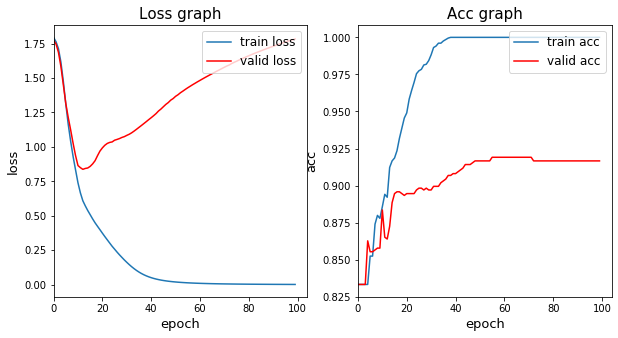

In [24]:
#Loss graph
%matplotlib inline

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.plot(train_history['loss'].tolist(), label='train loss')
ax.plot(valid_history['loss'].tolist(), label='valid loss', color='Red')

#ax.plot( range(val_freq, len(train_history)+val_freq, val_freq), valid_history['loss'], label='valid loss', marker='o', color='Red')
#ax.axis([0, len(train_history), 0, 1.0])
plt.xlim(0,None)
plt.legend(fontsize=12, loc='upper right')
plt.title('Loss graph', fontsize=15)
plt.xlabel('epoch', fontsize=13)
plt.ylabel('loss', fontsize=13)

plt.savefig(os.path.join(save_path, model_name, 'loss_graph.png'))

ax = fig.add_subplot(1,2,2)
ax.plot(train_history['acc'].tolist(), label='train acc')
ax.plot(valid_history['acc'].tolist(), label='valid acc', color='Red')

#ax.plot( range(val_freq, len(train_history)+val_freq, val_freq), valid_history['loss'], label='valid loss', marker='o', color='Red')
#ax.axis([0, len(train_history), 0, 1.0])
plt.xlim(0,None)
plt.legend(fontsize=12, loc='upper right')
plt.title('Acc graph', fontsize=15)
plt.xlabel('epoch', fontsize=13)
plt.ylabel('acc', fontsize=13)


plt.savefig(os.path.join(save_path, model_name, 'acc_graph.png'))


In [25]:
bestepoch = int(np.argmin(valid_history['loss']))

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


In [26]:
error = valid_history.loc[bestepoch,'loss']
print ("error: {}".format(error))

error: 0.8374994918704033


In [27]:
bestepoch=bestepoch
MC_dropout_model.load(os.path.join(save_path, model_name,str(bestepoch)+'.ckpt'))

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Colab Notebooks/Explaining_Decision_of_Time_Series_Data/savedmodel/ICML(har)_CNN_MCdropout1.0_0.001_34/12.ckpt
Model restored


### with confusion matrix

In [0]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig=plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.subplot(122)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.tight_layout()
    plt.show()

In [0]:
class_list = np.unique(y_train, return_counts=False, return_index=True)[0].astype(int)

In [0]:
fname='HAR'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


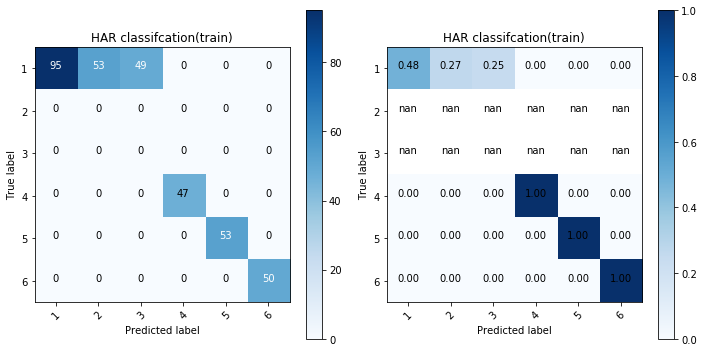

In [31]:
prediction = MC_dropout_model.predict(data=trainX,keep_prob=1.0,is_dropout=False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(trainY,axis=1)

plot_confusion_matrix(confusion_matrix(prediction,target),                      
    classes=class_list,
    title='HAR'+' classifcation(train)')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


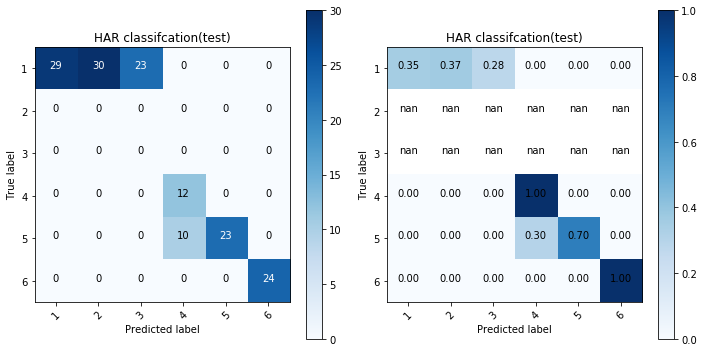

In [32]:
prediction = MC_dropout_model.predict(data=testX,keep_prob=1.0,is_dropout=False)
prediction = np.argmax(prediction,axis=1)
target = np.argmax(testY,axis=1)

plot_confusion_matrix(confusion_matrix(prediction,target),                      
    classes=class_list,
    title=fname+' classifcation(test)')

# 5. Trained 된 모델에서 Last Conv output Load하기

In [0]:
import random

In [34]:
last_conv_output = MC_dropout_model.get_last_conv_output(data=trainX,keep_prob=1.0,is_dropout=False)[:,0,:,:]
last_conv_output.shape
threshold = np.percentile(last_conv_output,95)
print ("threshold: {}".format(threshold))

threshold: 1.697184443473816


In [35]:
#trainX를 인풋으로 넣었을 때, last conv layer 의 focused_conv_channel output 보기
last_conv_bool = last_conv_output>threshold
print (last_conv_bool.shape)

(347, 128, 128)


In [42]:
last_conv_bool[0]

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

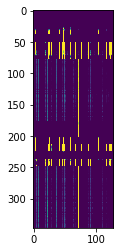

In [50]:
plt.imshow(last_conv_bool.sum(axis=1))

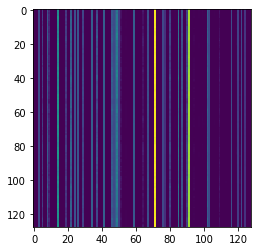

In [47]:
plt.imshow(last_conv_bool.sum(axis=0))

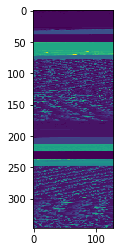

In [48]:
plt.imshow(last_conv_bool.sum(axis=2))

In [51]:
last_conv_bool[0].shape

(128, 128)

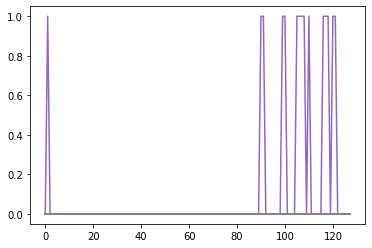

In [46]:

plt.plot(last_conv_bool[0])

ValueError: ignored

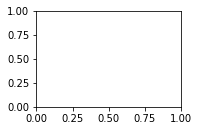

In [41]:
focused_label = 0

fig = plt.figure(figsize=(15,6))
#fig.suptitle("Last Conv ({}) Output(class{}) ".format(focused_conv_channel,focused_label))
pattern =[]
for i,x in enumerate(trainX[np.argmax(trainY,axis=1) == focused_label]):
    ax = plt.subplot(3,5,i+1)
    data = x.reshape(-1,1)
    pattern_idx = [i for i, x in enumerate(last_conv_bool[i]) if x]
    ax.plot(data,color='black')
    if pattern_idx:
        ax.scatter(pattern_idx, data[pattern_idx],color = "cyan")
    if i==14:
        break

In [0]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 12

In [0]:
from itertools import groupby, count
from operator import itemgetter

IndexError: ignored

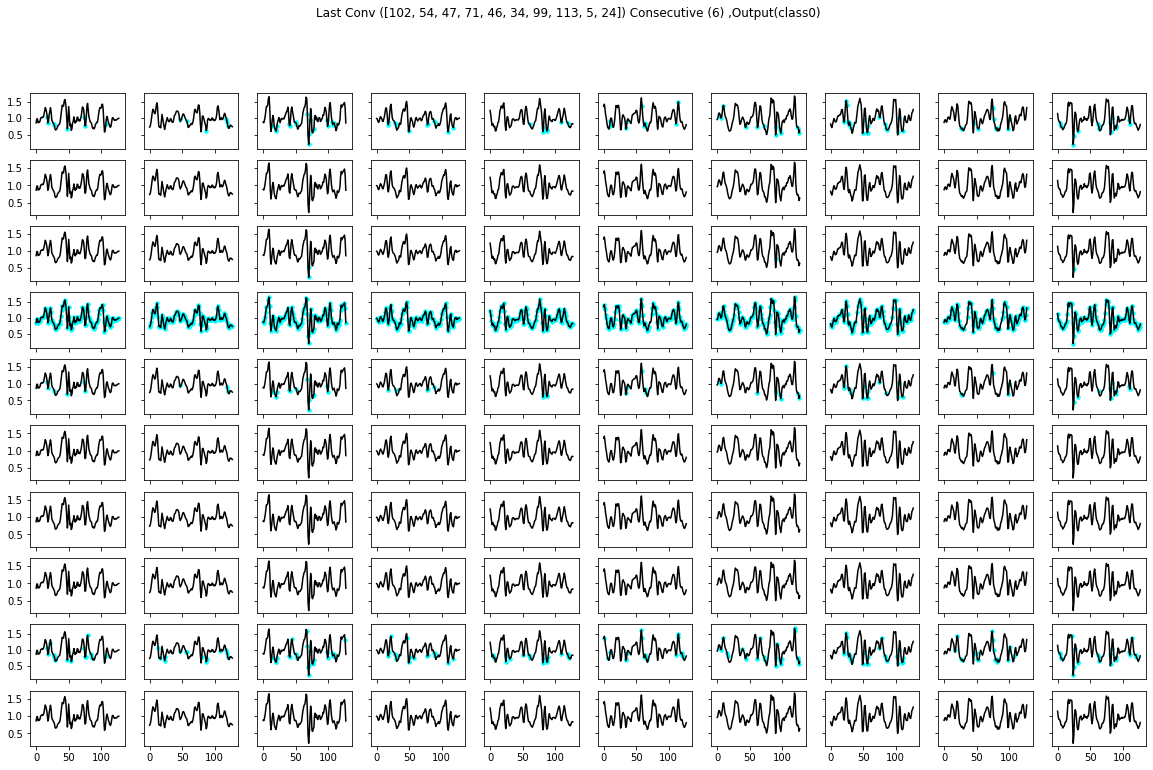

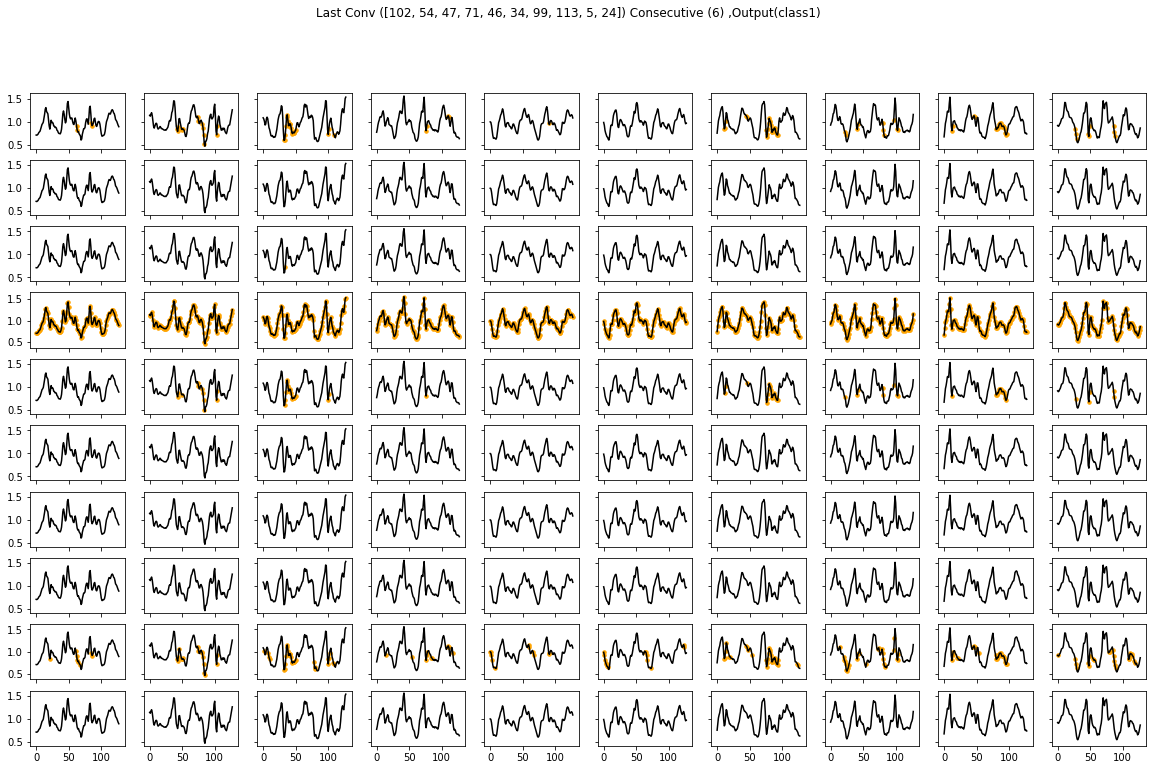

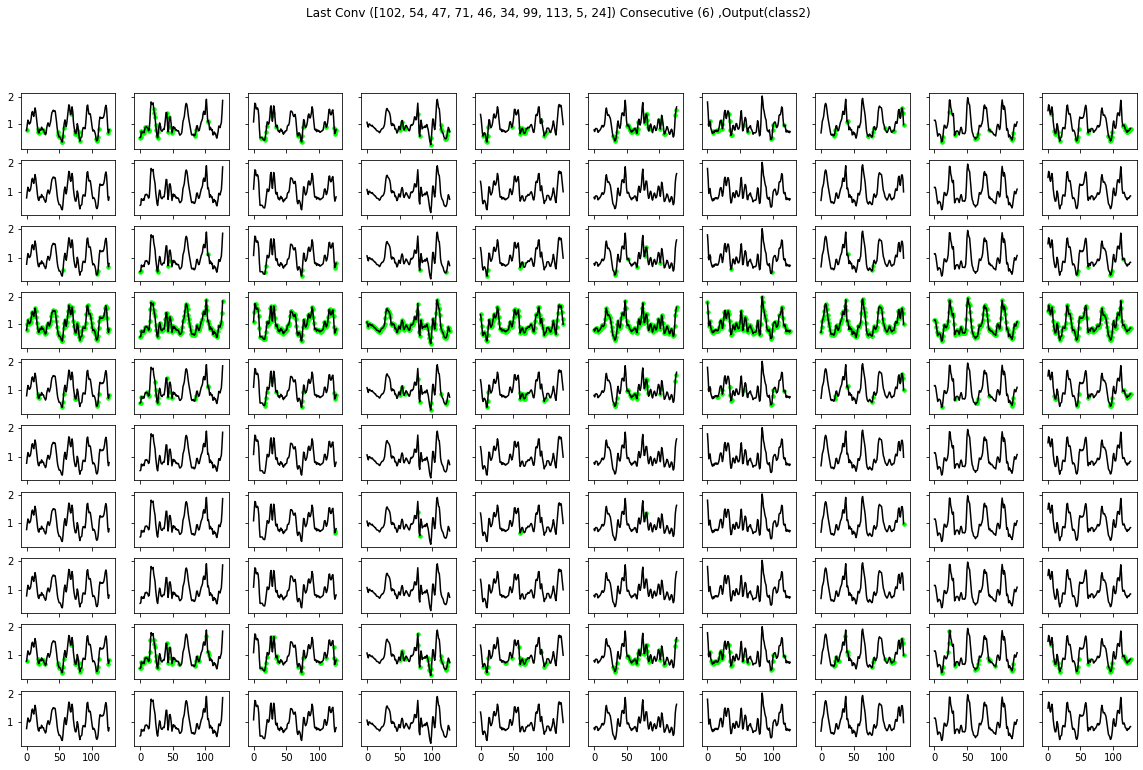

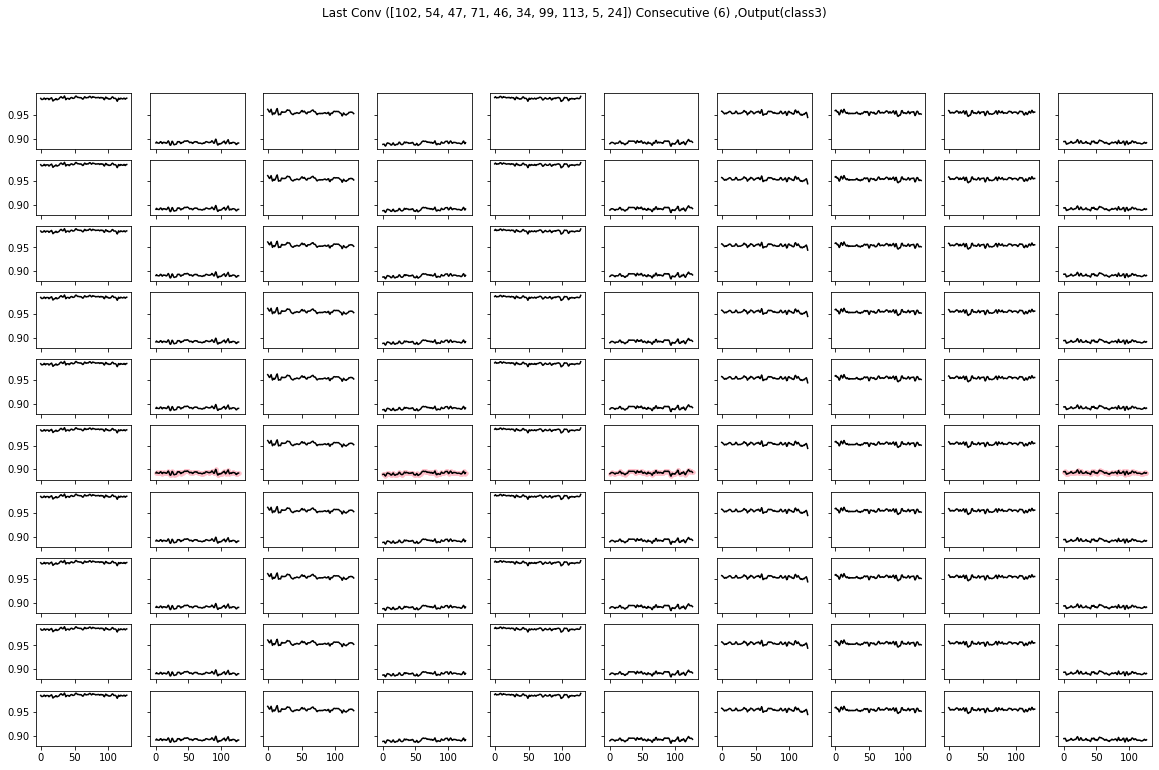

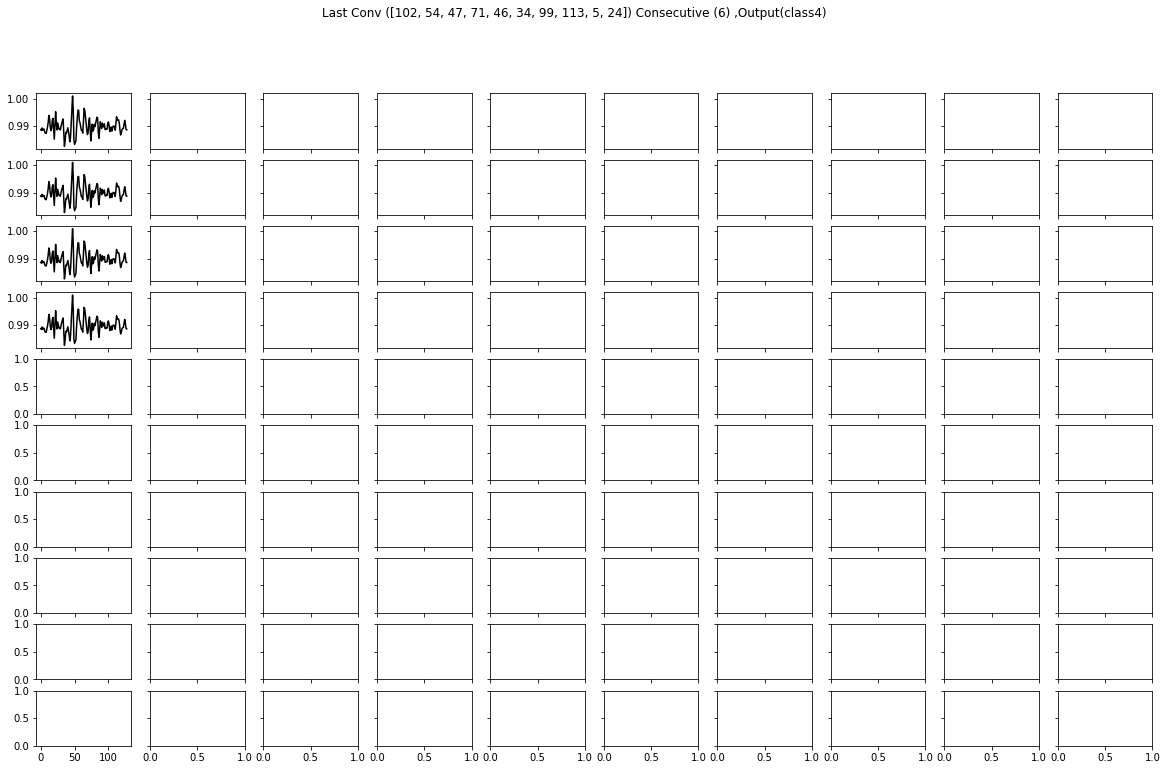

In [57]:
random.seed = 10005

class_color= ["cyan","orange","lime","pink"]
consecutive_class_color= ["dodgerblue","coral","seagreen","indianred"]
survived_channel = [i for i, x in enumerate(last_conv_bool.sum(axis=1).sum(axis=0)) if x>0]
sample_channel = random.sample(survived_channel,10)

consecutive_num =trainX.shape[2]//20

for class_i in class_list:
    
    sample_data_idx =random.sample([i for i, e in enumerate(np.argmax(trainY,axis=1)) if e == (class_i-1)],10)
    fig, ax = plt.subplots(len(sample_channel), len(sample_data_idx), sharex='col', sharey='row')
    fig.suptitle("Last Conv ({}) Consecutive ({}) ,Output(class{}) ".format(sample_channel,consecutive_num,class_i-1))
    
    ax_idx = 0
    for i, x_idx in enumerate(sample_data_idx):
        for j,channel in enumerate(sample_channel) : 
            data = trainX[x_idx][:,:,0] # 첫번째 채널만 시각화
            data = data.reshape(-1,1)
            pattern_idx = [p for p, x in enumerate(last_conv_bool[x_idx,:,channel]) if x]
            
            # 패턴의 연속성을 찾는 구간
            groups = []
            for _, g in groupby(pattern_idx, key=lambda n, c=count(): n-next(c)):
                groups.append(list(g))    # Store group iterator as a list
    
            ax[j,i].set_xticks=[]
            ax[j,i].set_yticks=[]
            ax[j,i].plot(data,color='black')
            for g in groups:
                # if len(g)>consecutive_num:
                #     ax[j,i].scatter(g, data[g],color = consecutive_class_color[class_i-1], s =12,alpha=0.8)
                #     ax[j,i].text(g[0],0,len(g))
                # else:
                    ax[j,i].scatter(g, data[g],color = class_color[class_i-1],s=12)

In [0]:
random.seed = 10005

class_color= ["cyan","orange","lime","pink"]
consecutive_class_color= ["dodgerblue","coral","seagreen","indianred"]
survived_channel = [i for i, x in enumerate(last_conv_bool.sum(axis=1).sum(axis=0)) if x>0]
sample_channel = random.sample(survived_channel,10)

consecutive_num =trainX.shape[2]//20

for class_i in class_list:
    
    sample_data_idx =random.sample([i for i, e in enumerate(np.argmax(trainY,axis=1)) if e == (class_i-1)],10)
    fig, ax = plt.subplots(len(sample_channel), len(sample_data_idx), sharex='col', sharey='row')
    fig.suptitle("Last Conv ({}) Consecutive ({}) ,Output(class{}) ".format(sample_channel,consecutive_num,class_i-1))
    
    ax_idx = 0
    for i, x_idx in enumerate(sample_data_idx):
        for j,channel in enumerate(sample_channel) : 
            data = trainX[x_idx].reshape(-1,1)
            pattern_idx = [p for p, x in enumerate(last_conv_bool[x_idx,:,channel]) if x]
            
            # 패턴의 연속성을 찾는 구간
            groups = []
            for _, g in groupby(pattern_idx, key=lambda n, c=count(): n-next(c)):
                groups.append(list(g))    # Store group iterator as a list
    
            ax[j,i].set_xticks=[]
            ax[j,i].set_yticks=[]
            ax[j,i].plot(data,color='black')
            for g in groups:
                if len(g)>consecutive_num:
                    ax[j,i].scatter(g, data[g],color = consecutive_class_color[class_i-1], s =12,alpha=0.8)
                    ax[j,i].text(g[0],0,len(g))
                else:
                    ax[j,i].scatter(g, data[g],color = class_color[class_i-1],s=12)